In [4]:
import cv2
import os
import os.path
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader


In [5]:
width = 25
height = 25
channel = 1
video_path = '../../RawData/InputVideo/Train_Video'
label_path = '../../RawData/InputVideo/Train_Label'

## File Loader

In [6]:
files = {'all_video': [f for f in sorted(os.listdir(video_path)) if f.endswith('.avi')],
         'all_label': [f for f in sorted(os.listdir(label_path)) if f.endswith('.txt')],
         'train_video': [],
         'train_label': [],
         'test_video': [],
         'test_label': []}

for index, (video, label) in enumerate(zip(files['all_video'], files['all_label'])):
    if index % 4 == 0:
        files['test_video'].append(video)
        files['test_label'].append(label)
    else:
        files['train_video'].append(video)
        files['train_label'].append(label)

for name, fileList in files.items():
    print(name + '\r')
    print(fileList)

all_video
['STMD_0.avi', 'STMD_1.avi', 'STMD_2.avi', 'STMD_3.avi', 'STMD_4.avi', 'STMD_5.avi', 'STMD_6.avi', 'STMD_7.avi', 'STMD_8.avi', 'STMD_9.avi']
all_label
['STMD_0.txt', 'STMD_1.txt', 'STMD_2.txt', 'STMD_3.txt', 'STMD_4.txt', 'STMD_5.txt', 'STMD_6.txt', 'STMD_7.txt', 'STMD_8.txt', 'STMD_9.txt']
train_video
['STMD_1.avi', 'STMD_2.avi', 'STMD_3.avi', 'STMD_5.avi', 'STMD_6.avi', 'STMD_7.avi', 'STMD_9.avi']
train_label
['STMD_1.txt', 'STMD_2.txt', 'STMD_3.txt', 'STMD_5.txt', 'STMD_6.txt', 'STMD_7.txt', 'STMD_9.txt']
test_video
['STMD_0.avi', 'STMD_4.avi', 'STMD_8.avi']
test_label
['STMD_0.txt', 'STMD_4.txt', 'STMD_8.txt']


## Video and label loader and preprocessing
```
variable name: videos
type: dictionary, key: 视频文件名称
                  value: tensor张量(shape = [9000, 1, 25, 25], [num of frames, channel, width, height])
variable name: spike_times
type: dictionary, key: label文件名称
                  value: tensor张量（shape = [9000], [num of frames])
                  description: one-hot vector with spiking time of 1, 0 otherwise
```

In [7]:
num_frames = 0

## Load Videos with frames
videos = {}
for filename in files['all_video']:
    videoLoader = cv2.VideoCapture(video_path + "/" + filename)
    n = 0
    frame_tensors = []
    while True:
        ret, frame = videoLoader.read()
        if ret is False:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)         # 1. 将BGR图像转换为灰度图
        frame_gray = frame_gray.astype(np.float32) / 255.0           # 2. 将数据类型转换为float32，并缩放到0-1范围
        frame_resized = cv2.resize(frame_gray, (width, height))      # 3. 重新调整图像尺寸（如果需要保持原尺寸，这一步可以省略）       
        frame_tensor = torch.tensor(frame_resized).unsqueeze(0)
        frame_tensors.append(frame_tensor)
    num_frames = len(frame_tensors)
    videoLoader.release()
    videos[filename] = torch.stack(frame_tensors) ## shape: [1, 25, 25] [channel, width, height]

print(videos['STMD_0.avi'].shape)

## Load Labels
spike_times = {}
for labelName in files['all_label']:
    spikes = [0] * num_frames
    with open(label_path + "/" + labelName, 'r') as file:
        for line in file:
            try:
                spike_index = int(line.strip())
                spikes[spike_index] = 1
            except ValueError:
                print(f"Skipping invalid number: {line.strip()}")
    spike_tensor = torch.tensor([element for element in spikes])
    spike_times[labelName] = spike_tensor

torch.Size([9000, 1, 25, 25])


STMD_0.txt
STMD_1.txt
STMD_2.txt
STMD_3.txt
STMD_4.txt
STMD_5.txt


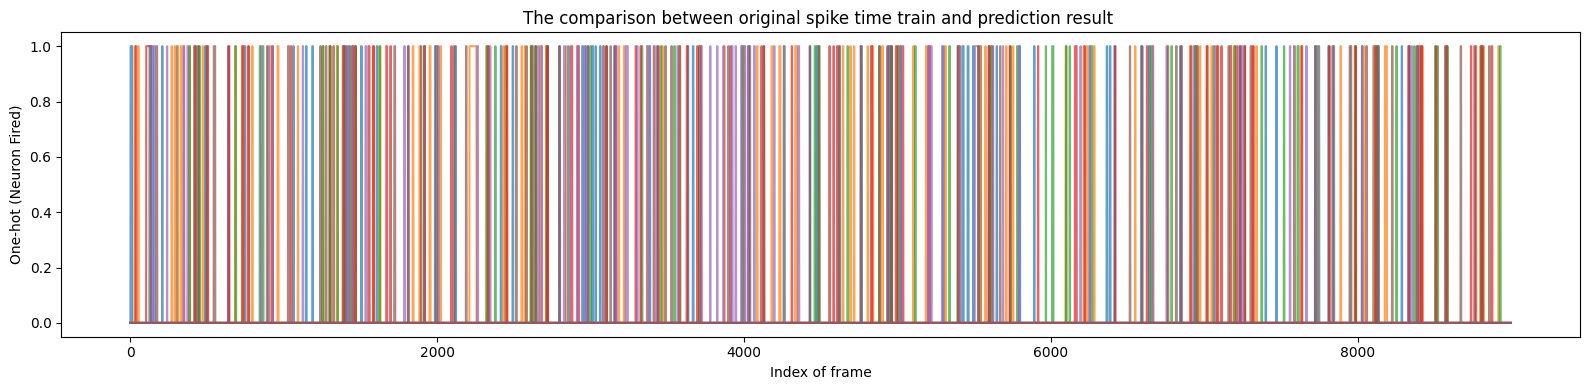

In [17]:
plt.figure(figsize = (16,4))
for index, (name, one_hot) in enumerate(spike_times.items()):
    print(name)
    one_array = one_hot.numpy()
    plt.tight_layout()
    plt.plot(one_array, alpha = 0.7)
    plt.xlabel('Index of frame')
    plt.ylabel('One-hot (Neuron Fired)')
    plt.title("The spike train for several neurons ")
    if index == 5:
        break
plt.show()

In [42]:
def get_window_size(spike_times):
    lengths = []
    for one_hot in spike_times.values():
        count = 0
        for item in one_hot:
            if item == 1:
                count += 1
            else:
                if count > 0:
                    lengths.append(count)
                    count = 0 
    
        if count > 0:
            lengths.append(count)  # 处理数组末尾的连续1
            
    if lengths:
        avg_length =  sum(lengths) / len(lengths)  # 计算平均长度
    else:
        avg_length = 0
    return (lengths, (round(avg_length) + 1)*2)

10


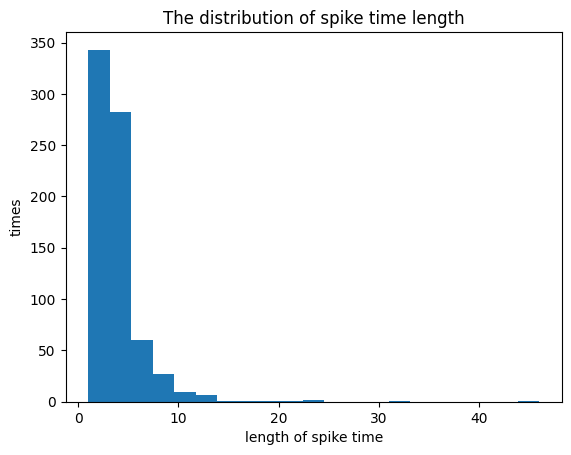

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [7]:
lengths, window_size = get_window_size(spike_times)
print(window_size)
plt.figure
plt.hist(lengths, bins=21)
plt.xlabel('length of spike time')
plt.ylabel('times')
plt.title('The distribution of spike time length')
plt.show()
print(sorted(lengths))

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class VideoFrameDataset(Dataset):
    def __init__(self, video_frames_dict, labels_dict, window_size):
        self.video_frames_dict = video_frames_dict
        self.labels_dict = labels_dict
        self.window_size = window_size
        self.samples = self._generate_samples()

    def _generate_samples(self):
        samples = []
        for filename, frames in self.video_frames_dict.items():
            num_frames = len(frames)
            for start in range(0, (num_frames - self.window_size + 1), 2):
                end = start + self.window_size
                samples.append((filename, start, end))
        return samples
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename, start, end = self.samples[idx]
        frames = self.video_frames_dict[filename][start:end, :, :]  # [window_size, 1, 25, 25]
        labels = self.labels_dict[os.path.splitext(filename)[0] + '.txt'][start:end]  # [sequence_length, num_classes]
        return frames, labels

In [9]:
def show_image(tensor_list, title):
    
    # 将选定的帧转换为numpy数组
    frame_np = tensor_list.squeeze().detach().numpy()  # 直接使用squeeze()和numpy()，省略permute()
    
    # 将数据类型从float转换回uint8（如果之前进行了归一化）
    frame_np = (frame_np * 255).astype(np.uint8)
    
    plt.imshow(frame_np, cmap='gray')  # 对于灰度图，确保使用正确的颜色映射
    plt.axis('off')  # 不显示坐标轴
    plt.title(title)
    plt.show()

In [10]:
train_video={}
train_label={}
test_video={}
test_label={}
for name in files['train_video']:
    label_name = os.path.splitext(name)[0] + '.txt'
    train_video[name] = videos[name]
    train_label[label_name] = spike_times[label_name]

for name in files['test_video']:
    label_name = os.path.splitext(name)[0] + '.txt'
    test_video[name] = videos[name]
    test_label[label_name] = spike_times[label_name]

print(train_video.keys())
print(train_label.keys())
print(test_video.keys())
print(test_label.keys())

dict_keys(['STMD_1.avi', 'STMD_2.avi', 'STMD_3.avi', 'STMD_5.avi', 'STMD_6.avi', 'STMD_7.avi', 'STMD_9.avi'])
dict_keys(['STMD_1.txt', 'STMD_2.txt', 'STMD_3.txt', 'STMD_5.txt', 'STMD_6.txt', 'STMD_7.txt', 'STMD_9.txt'])
dict_keys(['STMD_0.avi', 'STMD_4.avi', 'STMD_8.avi'])
dict_keys(['STMD_0.txt', 'STMD_4.txt', 'STMD_8.txt'])


## Data Load process

In [11]:
## Hyperparameter Setting
window_size = 100
batch_size = 10

In [12]:
# Assuming `video_frames_dict` and `labels_dict` are your dictionaries

train_set = VideoFrameDataset(train_video, train_label, window_size)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = VideoFrameDataset(test_video, test_label, window_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

print(len(train_loader))
# In your training loop
data_iter = iter(train_loader)
frames, labels = next(data_iter)
print(frames.shape)
first_item_batch = frames[0]
# plt.figure()
# for index, frame in enumerate(first_item_batch):
#     show_image(frame, f'the {index}th image')
# print(labels[0])

3116
torch.Size([10, 100, 1, 25, 25])


## 前期数据加载完成：
1. 数据以dataloader的形式存储,分别以train_loader, test_loader 存储训练集和测试集
2. 训练集和测试集都包含: \ 
   1. frames.shape = [10,5,1,25,25]: [batch size, frame num, channel, width, height] \
   2. label.shape = [10,5]: [batch size, frame 1-hot]

## LSTM 模型构建与autoencoder应用
目标：1. 对现有数据集进行降维处理以及特征提取
     2. 将连续帧输入模型
     3. 输出结果为每组5个标签。

n_samples 样本量为10 * 3149 一共31490个样本
n_timesteps 时间步，每个样本含有五个时间步
n_features 特征数：每张图像含有25*25个特征

1. 对图像进行降维处理: LSTM encoder

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

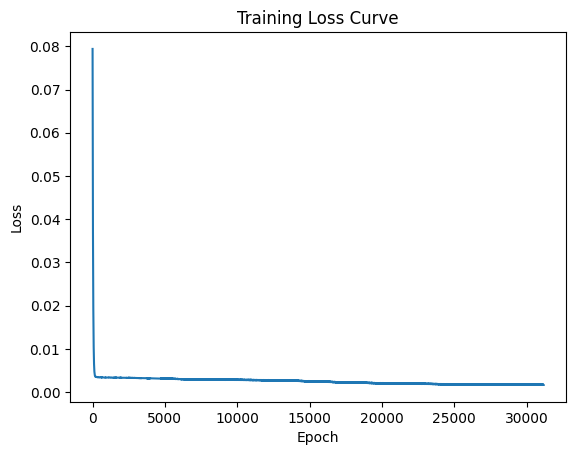

In [19]:
'''
from LSTM import LinearAutoencoder2

linear2 = LinearAutoencoder2()
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(linear2.parameters(), lr=learning_rate)
EPOCHS = 10
loss_value = []
linear2.train()
for epoch in range(1, EPOCHS + 1):
    loss = 0
    processBar = tqdm(train_loader, unit='step')
    for step, (trainImgs, labels) in enumerate(processBar):
        optimizer.zero_grad()
        # 前向传播
        outputs = linear2(trainImgs)
        # 计算损失
        loss = criterion(outputs, trainImgs)  # 使用输入作为目标进行重构
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        processBar.set_description(f"[{epoch}/{EPOCHS}] Loss: {loss.item():.10f}")
        loss_value.append(loss.item())
'''


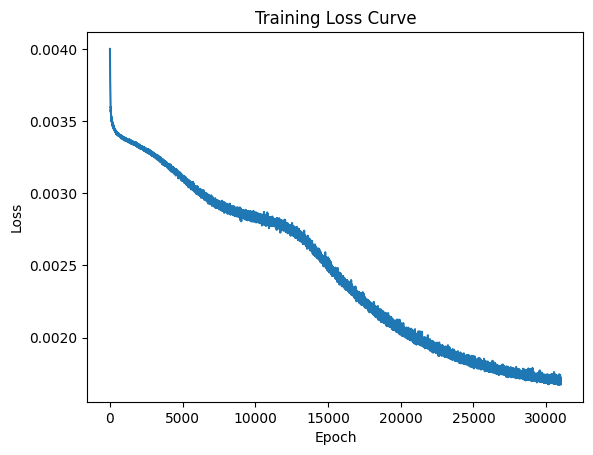

In [27]:
'''
plt.figure()
plt.plot(loss_value[150:])
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
'''

In [126]:
'''
show_image(outputs[0][0], title = 'output image')
show_image(trainImgs[0][0], title = 'original image')

linear2.eval()  # 将模型设置为评估模式

test_loss = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for testImgs, _ in test_loader:  # 假设test_loader是您的测试数据加载器
        # 前向传播
        reconstructed_imgs = linear2(testImgs)
        # 计算损失
        test_loss += criterion(reconstructed_imgs, testImgs).item()

# 计算平均损失
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

show_image(reconstructed_imgs[0][0], title = 'reconstructed image')
show_image(testImgs[0][0], title = 'original tested image')
'''

"\nshow_image(outputs[0][0], title = 'output image')\nshow_image(trainImgs[0][0], title = 'original image')\n\nlinear2.eval()  # 将模型设置为评估模式\n\ntest_loss = 0\nwith torch.no_grad():  # 在评估过程中不计算梯度\n    for testImgs, _ in test_loader:  # 假设test_loader是您的测试数据加载器\n        # 前向传播\n        reconstructed_imgs = linear2(testImgs)\n        # 计算损失\n        test_loss += criterion(reconstructed_imgs, testImgs).item()\n\n# 计算平均损失\navg_test_loss = test_loss / len(test_loader)\nprint(f'Average Test Loss: {avg_test_loss:.4f}')\n\nshow_image(reconstructed_imgs[0][0], title = 'reconstructed image')\nshow_image(testImgs[0][0], title = 'original tested image')\n"

In [128]:
'''
from LSTM import LSTMCovAutoencoder

autoencoder = LSTMCovAutoencoder()
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
EPOCHS = 10
loss_value = []
for epoch in range(1, EPOCHS + 1):
    loss = 0
    processBar = tqdm(train_loader, unit='step')
    for step, (trainImgs, labels) in enumerate(processBar):
        optimizer.zero_grad()
        # 前向传播
        outputs = autoencoder(trainImgs)
        # 计算损失
        loss = criterion(outputs, trainImgs)  # 使用输入作为目标进行重构
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        processBar.set_description(f"[{epoch}/{EPOCHS}] Loss: {loss.item():.10f}")
        loss_value.append(loss.item())

show_image(outputs[0][0])
'''

'\nfrom LSTM import LSTMCovAutoencoder\n\nautoencoder = LSTMCovAutoencoder()\ncriterion = nn.MSELoss()\nlearning_rate = 0.0001\noptimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)\nEPOCHS = 10\nloss_value = []\nfor epoch in range(1, EPOCHS + 1):\n    loss = 0\n    processBar = tqdm(train_loader, unit=\'step\')\n    for step, (trainImgs, labels) in enumerate(processBar):\n        optimizer.zero_grad()\n        # 前向传播\n        outputs = autoencoder(trainImgs)\n        # 计算损失\n        loss = criterion(outputs, trainImgs)  # 使用输入作为目标进行重构\n        # 反向传播\n        loss.backward()\n        # 参数更新\n        optimizer.step()\n        processBar.set_description(f"[{epoch}/{EPOCHS}] Loss: {loss.item():.10f}")\n        loss_value.append(loss.item())\n\nshow_image(outputs[0][0])\n'

In [17]:
from LSTM import LSTMAutoencoder
from common import select_device
'''
device = select_device("mps")
autoencoder = LSTMAutoencoder().to(device)
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
EPOCHS = 10
loss_value = []
autoencoder.train()
for epoch in range(1, EPOCHS + 1):
    loss = 0
    processBar = tqdm(train_loader, unit='step')
    for step, (trainImgs, labels) in enumerate(processBar):
        trainImgs, labels = trainImgs.to(device), labels.to(device)
        optimizer.zero_grad()
        # 前向传播
        outputs = autoencoder(trainImgs)
        # 计算损失
        loss = criterion(outputs, trainImgs)  # 使用输入作为目标进行重构
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        processBar.set_description(f"[{epoch}/{EPOCHS}] Loss: {loss.item():.10f}")
        loss_value.append(loss.item())
'''

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

  0%|          | 0/3116 [00:00<?, ?step/s]

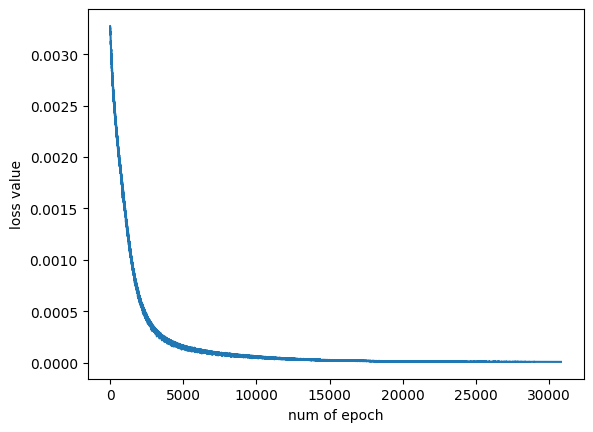

In [18]:
plt.figure()
plt.plot(loss_value[350:])
plt.xlabel('num of epoch')
plt.ylabel('loss value')
plt.show()

In [ ]:
'''
autoencoder.eval()  # 将模型设置为评估模式

test_loss = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for testImgs, _ in test_loader:  # 假设test_loader是您的测试数据加载器
        # 前向传播
        reconstructed_imgs = autoencoder(testImgs)
        # 计算损失
        test_loss += criterion(reconstructed_imgs, testImgs).item()

# 计算平均损失
avg_test_loss = test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')

show_image(reconstructed_imgs[0][0], 'reconstructed image')
show_image(testImgs[0][0], 'original tested image')
'''

In [26]:
def precision_cal(encoder, predictor, test_loader, save=False, calculate=True, device=None):
    device = device
    encoder.eval()
    predictor.eval()  # 将模型设置为评估模式
    criterion = nn.BCELoss()
    avg_test_loss = 0
    avg_test_precision = 0
    sample_total = 0

    total_output = []
    threshold = 1.0e-01
    with torch.no_grad():  # 在评估过程中不计算梯度
        avg_correct = 0
        test_loss = 0
        avg_accuracy = 0
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        
        for testImgs, testLabel in test_loader:  # 假设test_loader是您的测试数据加载器
            # 前向传播
            testImgs, testLabel = testImgs.to(device), testLabel.to(device)
            # 前向传播
            outputs = predictor(testImgs)
            test_loss += criterion(outputs, testLabel.float()).item()
            batch_size, seq_len = outputs.size()
            if save: 
                result = torch.zeros([batch_size, seq_len], dtype=torch.int)
                for b_index, res_batch in enumerate(outputs):
                    for i_index, res_it in enumerate(res_batch):
                        if res_it >= 1.0e-01:
                            result[b_index][i_index] = 1
                total_output.append(result)
            
            if calculate: 
                for res_batch, label_batch in zip(outputs, testLabel): ## 遍历一个batch的sequence length组数据
                    for res_it, label_it in zip(res_batch, label_batch): ## 从每一组数据中取一帧的label
                        sample_total += 1
                        if res_it >= threshold and label_it == 1:
                            TP += 1
                        elif res_it <= threshold and label_it == 0:
                            TN += 1
                        elif res_it >= threshold and label_it == 0:
                            FP += 1
                        elif res_it <= threshold and label_it == 1:
                            FN += 1

    avg_accuracy = ((TP + TN) / sample_total)
    precision = TP/(TP + FP)        
    recall = TP / (TP+FN)
    # 计算平均损失
    avg_test_loss = test_loss / len(test_loader)

    return (avg_accuracy, precision, recall), avg_test_loss, total_output

In [27]:
from LSTM import Predictor, LSTMEncoder
from common import select_device
device = select_device("mps")
encoder = LSTMEncoder().to(device)
predictor = Predictor(encoder).to(device)
criterion = nn.BCELoss()
learning_rate = 0.0001
optimizer = optim.Adam(predictor.parameters(), lr=learning_rate)
EPOCHS = 20
loss_value = []
precisions = []
predictor.train()
for epoch in range(1, EPOCHS + 1):
    loss = 0
    processBar = tqdm(train_loader, unit='step')
    for step, (trainImgs, labels) in enumerate(processBar):
        trainImgs, labels = trainImgs.to(device), labels.to(device)
        optimizer.zero_grad()
        # 前向传播
        outputs = predictor(trainImgs)
        # 初始化BCE损失函数
        criterion = nn.BCELoss()
        # 计算损失
        loss = criterion(outputs, labels.float())
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        processBar.set_description(f"[{epoch}/{EPOCHS}] train Loss: {loss.item():.10f}")
    
    score, test_loss,_ = precision_cal(encoder, predictor, test_loader, calculate = True, device=device)
    print(f"Epoch {epoch}: scores for test = {score}, Avarage test loss = {test_loss}")
    _, precision, _ = score
    precisions.append(precision)
    loss_value.append(loss.item())

  0%|          | 0/3116 [00:00<?, ?step/s]

KeyboardInterrupt: 

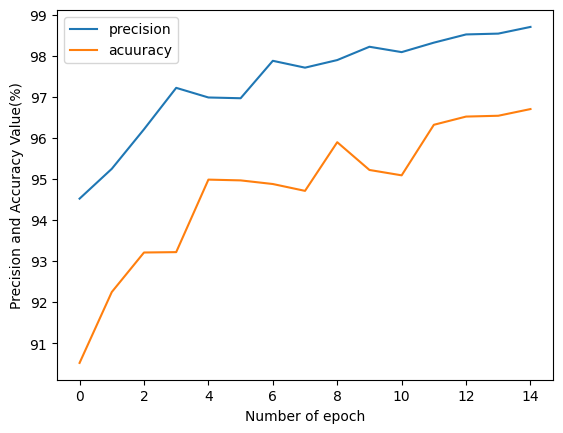

In [41]:
accuracy_list = [94.52212985845877, 95.24825881824309, 96.21058938066352, 97.2198007938291, 96.98532165056541,
                96.96667415562046, 97.8782296113233, 97.71145061034974, 97.89620310042687, 98.22032502059462, 98.089620310042687,
                98.32032502059462,  98.52032502059462, 98.54032502059462, 98.7032502059462]


accuracy_list2 = [90.52212985845877, 92.24825881824309, 93.21058938066352, 93.2198007938291, 94.98532165056541,
                94.96667415562046, 94.8782296113233, 94.71145061034974, 95.89620310042687, 95.22032502059462, 95.089620310042687,
                96.32032502059462,  96.52032502059462, 96.54032502059462, 96.7032502059462]

plt.figure()
plt.plot(accuracy_list)
plt.plot(accuracy_list2)
plt.xlabel("Number of epoch")
plt.ylabel("Precision and Accuracy Value(%)")
plt.legend(["LSTM Predictor", "Linear Predictor"])
plt.show()



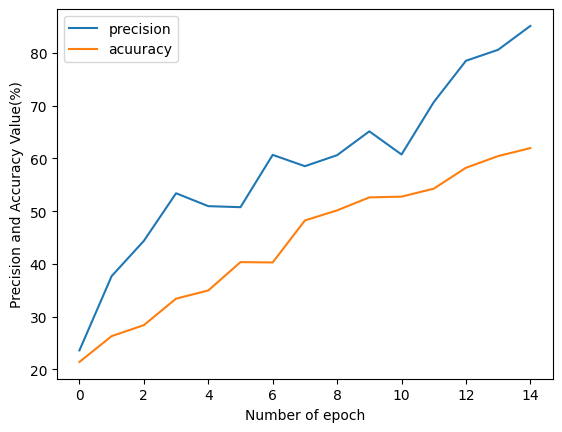

In [40]:
precision_list = [23.576963069801765, 37.67208445418993, 44.358148082878074, 53.39227715626128, 50.9450747984616,
                 50.74899428329451, 60.67462609923615, 58.52772260458527, 60.61841445057702, 65.14319606846297, 
                 60.74899428329451, 70.67462609923615, 78.52772260458527, 80.61841445057702, 85.14319606846297]

precision_list2 = [21.386963069801765, 26.28208445418993, 28.368148082878074, 33.39227715626128, 34.9450747984616,
                 40.32459428329451, 40.2609923615, 48.2260458527, 50.1445057702, 52.606846297, 
                 52.74899428329451, 54.2609923615, 58.2260458527, 60.445057702, 61.9606846297]

plt.figure()
plt.plot(precision_list)
plt.plot(precision_list2)
plt.xlabel("Number of epoch")
plt.ylabel("Precision and Accuracy Value(%)")
plt.legend(["LSTM Predictor", "Linear Predictor"])
plt.show()

In [ ]:
score, _, result = precision_cal(encoder, predictor, test_loader, calculate = True, save = True)
print(score)
for step, (_, labels) in enumerate(test_loader):
    print('result:','\n', result[step])
    print('label:', '\n', labels)

In [ ]:
batch_size, seq_len = outputs.size()
result = torch.zeros([batch_size, seq_len], dtype=torch.int)
for b_index, res_batch in enumerate(outputs):
    for i_index, res_it in enumerate(res_batch):
        if res_it >= 1.0e-01:
            result[b_index][i_index] = 1
print(result, testLabel)



## ===========================================================================================================================================

In [13]:
import cv2
import os.path
import numpy as np
import os
import torch
from torch.utils.data import Dataset


class VideoFrameDataset(Dataset):
    def __init__(self, video_frames_dict, labels_dict, window_size, stride):
        self.stride = stride
        self.video_frames_dict = video_frames_dict
        self.labels_dict = labels_dict
        self.window_size = window_size
        self.samples = self._generate_samples()

    def _generate_samples(self):
        samples = []
        for labelName, (filename, frames) in zip(self.labels_dict, self.video_frames_dict.items()):
            num_frames = len(frames)
            for start in range(0, (num_frames - self.window_size + 1), self.stride):
                end = start + self.window_size
                samples.append((labelName, filename, start, end))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        labelName, fileName, start, end = self.samples[idx]
        frames = self.video_frames_dict[fileName][start:end, :, :]  # [window_size, 1, 25, 25]
        labels = self.labels_dict[labelName][start:end]  # [sequence_length, num_classes]
        return frames, labels


def DataFileLoad(train_video, train_label, test_video="", test_label=""):
    video_file = ('.avi', '.mp4')
    if len(test_video) == 0 and len(test_label) == 0:
        files = {
            'all_video': [train_video + '/' + f for f in sorted(os.listdir(train_video)) if f.endswith(video_file)],
            'all_label': [train_label + '/' + f for f in sorted(os.listdir(train_label)) if f.endswith('.txt')],
            'train_video': [],
            'train_label': [],
            'test_video': [],
            'test_label': []}
        for index, (video, label) in enumerate(zip(files['all_video'], files['all_label'])):
            if index % 4 == 0:
                files['test_video'].append(video)
                files['test_label'].append(label)
            else:
                files['train_video'].append(video)
                files['train_label'].append(label)
        del files['all_video']
        del files['all_label']
    else:
        files = {
            'train_video': [train_video + '/' + f for f in sorted(os.listdir(train_video)) if f.endswith(video_file)],
            'train_label': [train_label + '/' + f for f in sorted(os.listdir(train_label)) if f.endswith('.txt')],
            'test_video': [test_video + '/' + f for f in sorted(os.listdir(test_video)) if f.endswith(video_file)],
            'test_label': [test_label + '/' + f for f in sorted(os.listdir(test_label)) if f.endswith('.txt')]}
    return files


def DataLoad(video_path, label_path, imgz):
    """
    Description: Preprocess of input video and label files, load the video and label files as continuous tensor files
    Parameters: video_path: The root path for videos
                video_file: The file name for each videos
                label_path: The root path for labels
                label_file: The file name for each labels
                imgz: The size for frame resize
    output: videos: A dictionary take the file name as key and tensor list stored each frame as value;
            spike_times: A dictionary take the label file name as key and a tensor list maintaining one-hot list for
                         spiking frames
    """
    ## Load Videos with frames
    width, height = imgz
    videos = {}
    spike_times = {}
    for videoName, labelName in zip(video_path, label_path):
        num_frames = 0
        videoLoader = cv2.VideoCapture(videoName)
        frame_tensors = []
        while True:
            num_frames += 1
            ret, frame = videoLoader.read()
            if ret is False:
                break
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # 1. 将BGR图像转换为灰度图
            frame_gray = frame_gray.astype(np.float32) / 255.0  # 2. 将数据类型转换为float32，并缩放到0-1范围
            frame_resized = cv2.resize(frame_gray, (width, height))  # 3. 重新调整图像尺寸（如果需要保持原尺寸，这一步可以省略）
            frame_tensor = torch.tensor(frame_resized).unsqueeze(0)
            frame_tensors.append(frame_tensor)
        videos[videoName] = torch.stack(frame_tensors)  ## shape: [1, 25, 25] [channel, width, height]
        videoLoader.release()

        spikes = [0] * num_frames
        with open(labelName, 'r') as file:
            for line in file:
                try:
                    spike_index = int(line.strip())
                    spikes[spike_index] = 1
                except ValueError:
                    print(f"Skipping invalid number: {line.strip()}")
        spike_tensor = torch.tensor([element for element in spikes])
        spike_times[labelName] = spike_tensor

    return videos, spike_times

In [14]:
import torch
from torch.utils.data import DataLoader
from common import precision_cal, select_device, model_train
from LSTM import LSTMEncoder, LSTMAutoencoder, Predictor

In [25]:
weight = "/Users/dongzhiyu/Desktop/ICL Collection/Individual Project/BioLearning/src/runs/predict/exp3/predictor.pt"
width = 25
height = 25
channel = 1
video_path = '../../InputVideo/Train_Video'
label_path = '../../InputVideo/Train_Label'
imgz=(25, 25)
window_size = 100
win_stride = 2
batch_size=10
device = select_device("mps")
# 加载保存的状态字典
predictor = torch.load(weight, map_location=device)


In [26]:
## load file names (relative path)
file_paths = DataFileLoad(train_video=video_path, train_label=label_path, test_video="",test_label="")
## Load label content and video frames from file path
train_video, train_label = DataLoad(video_path=file_paths['train_video'], label_path=file_paths['train_label'],
                                    imgz=imgz)
test_video, test_label = DataLoad(video_path=file_paths['test_video'], label_path=file_paths['test_label'],
                                  imgz=imgz)
## convert to Dataloader (DataSets)
train_set = VideoFrameDataset(train_video, train_label, window_size, stride=win_stride)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = VideoFrameDataset(test_video, test_label, window_size, stride=win_stride)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [27]:
data_loader_iter = iter(test_loader)
first_batch = next(data_loader_iter)
frames, labels = first_batch
print(frames.shape)
print(labels.shape)

torch.Size([10, 100, 1, 25, 25])
torch.Size([10, 100])


In [28]:
score, test_loss = precision_cal(predictor, test_loader, device)
print(f"scores for test = {score}; Average test loss = {test_loss}", end="   ")

scores for test = (0.9503010559424848, 0.2695738564302021, 0.2861919615807545); Average test loss = 1.9742380864654279   

In [20]:
import torch.nn as nn
def result_post_processing(predictor:nn.Module, dataloader, device):
    predictor.eval()
    threshold = 1.0e-01
    prob_results = []
    with torch.no_grad():  # 在评估过程中不计算梯度
        for testFrames, testLabels in dataloader:  # 假设test_loader是您的测试数据加载器
            testFrames, testLabels = testFrames.to(device=device), testLabels.to(device=device)
            outputs = predictor(testFrames)
            one_window = []
            for oneWindow in outputs:
                ### 添加上probability的比较， 第一组数据包含0-probability， 取0-4 帧
                ### 第二组数据包含2-22帧，如果该组数据中第2-4帧的probability 大于之前记录的0-4帧中2-4帧的probabiliy，则取前者，否则取第一组数据的2-4帧
                one_window.append(oneWindow[:2].cpu().numpy())
            prob_results.append(np.concatenate(one_window))
            # prob_results.append(one_batch)
    return prob_results

In [21]:
prob_result = result_post_processing(predictor, test_loader, device)

In [22]:
all_test = np.concatenate(prob_result)
all_test = all_test[:9000]
for index, item in enumerate(all_test):
    if item == 1:
        print(index)
        